In [ ]:
# notebook to run all the seismic analysis and processing in Olinger et al 2021

In [14]:
import numpy as np
import pathlib
import time
import h5py
import obspy
import types
import pyasdf
import pickle
import rasterio
import math
from datetime import datetime
from scipy.signal import butter
from scipy.signal import filtfilt
import matplotlib.pyplot as plt
from detection.stalta_detector import stalta_detector
from detection.master_event_correlation import correlate_master
from detection.master_event_correlation import threshold_detections
from detection.master_event_correlation import plot_catalog
from detection.template_match import make_templates
from detection.template_match import template_match
from detection.template_match import detection_timeseries
from clustering.clustering import get_input_waveforms
from clustering.clustering import load_waveform
from clustering.clustering import cluster_events
from clustering.clustering import plot_clusters
from location.compute_backazimuths import compute_backazimuths
from figures.figures import plot_backazimuths_on_imagery
from figures.figures import plot_events_and_gps
from figures.figures import get_stacks
from gps.gps import gps_ice_velocity

In [15]:
'''

Download data and remove instrumental response

'''

# specify path to save data- folders will be created in this directory
data_path = "/media/Data/Data/PIG/MSEED/"
xml_path = "/media/Data/Data/PIG/XML/HH/"

# pull the data from IRIS servers

# remove instrumental response

# update path to data so subsequent cells will use data with the instrumental response removed
data_path = data_path + "noIR/"

In [ ]:
'''

Run 2-band sta-lta detector to find template events

'''

# initialize detection parameter object and set parameters for stalta
d = types.SimpleNamespace()
d.low_freq = [0.01,1]
d.high_freq = [1,10]
d.tolerance = 120
d.low_thresh_on = 8
d.low_thresh_off = 2
d.high_thresh_on = 20
d.high_thresh_off = 2
d.sta_len = 10
d.lta_len = 300
d.num_stations = 3

# specify window to pull template around detection in seconds
d.buffer = [2*60,3*60]

# specify paths to data and metadata
d.data_path = data_path
d.xml_path = xml_path

# select number of processors
d.n_procs = 10

# run the detector and save ASDF dataset with waveforms and metadata
stalta_detector(d)

In [ ]:
'''

Cross correlate master event with the rest of the detections to identify best templates

'''

# set normalized cross correlation threshold for making templates
threshold = 0.9

# load catalog in read-only mode
ds = pyasdf.ASDFDataSet("outputs/detections/stalta_catalog.h5",mode='r')

# get waveforms for a single station 
waveforms = ds.waveforms.XC_PIG2.stream

# filter waveforms
freq = [0.05,1]
waveforms.taper(max_percentage=0.1, max_length=30.)
waveforms.filter("bandpass",freqmin=freq[0],freqmax=freq[1])

# set master event for correlation after plotting to see if it looks dispersive and has high SNR
for station in ds.ifilter(ds.q.starttime == "2013-07-10T00:33:54.290001Z",ds.q.station=="PIG2"):
    master_event = station.stream
    master_event.taper(max_percentage=0.1, max_length=30.)
    master_event.filter("bandpass",freqmin=freq[0],freqmax=freq[1])
    master_event.plot()
    
# correlate master with all other waveforms
correlation_coefficients, shifts = correlate_master(master_event,waveforms,master_event[0].stats.npts,"detection/stalta")

# apply threshold to choose best templates and make plots
threshold_detections(waveforms,correlation_coefficients,shifts,threshold)

# close ASDF dataset
del ds

In [ ]:
'''

Make ASDF dataset of templates for use in multiband template matching procedure

''' 

# set frequency limits for low and high frequency templates
low_freq = [0.05,1]
high_freq = [1,10]

# load catalog in read-only mode
ds = pyasdf.ASDFDataSet("outputs/detections/stalta_catalog.h5",mode='r')

# load list of template times
template_file = h5py.File('outputs/detections/template_times.h5', 'r')
template_times = list(template_file['timestamps'])
template_file.close()

# make all the templates
make_templates(ds,template_times,high_freq,low_freq,xml_path)

In [ ]:
'''

Plot each template to verify quality

''' 

# open ASDF dataset 
ds = pyasdf.ASDFDataSet("outputs/detections/templates.h5",mode='r')

# make plot of both frequency bands 
for event in ds.events:
    for station in ds.ifilter(ds.q.event == event):
        station.low.plot()
        station.high.plot()

In [ ]:
'''

Delete a few templates that are unsuitable for use in template matching

''' 

# delete a specific station's record of a particular event
for station in ds.ifilter(ds.q.starttime == "2013-03-23T05:46:55.24",ds.q.station == "PIG4"):
    del station.low
    del station.high
    
# close the dataset
del ds

In [ ]:
'''

Run 2-band template matching detection procedure

'''

# initialize detection parameter object and set parameters for template matching
d = types.SimpleNamespace()
d.low_freq = [0.05,1]
d.high_freq = [1,10]
d.tolerance = 120
d.low_thresh_on = 0.3
d.low_thresh_off = 0.1
d.high_thresh_on = 0.2
d.high_thresh_off = 0.1
d.num_stations = 3

# specify window to pull template around detection in seconds
d.buffer = [2*60,3*60]

# specify paths to data and metadata
d.data_path = data_path
d.xml_path = xml_path
                            
# select number of processors
d.n_procs = 18

# run the parallel template matching code
template_match(d)

In [ ]:
'''

Plots the results of template matching

'''

# load catalog
ds = pyasdf.ASDFDataSet("outputs/detections/template_matching_catalog.h5",mode='a')

# plot waveforms of each detection using obspy (slow and not recommended)
#plot_detections(ds)

# make basic histogram of detection times
detection_timeseries(ds,"outputs/detections/template_matching_timeseries.png")

# get waveforms for a single station 
ds.single_item_read_limit_in_mb=6000
waveforms = ds.waveforms.XC_PIG2.stream

# filter waveforms
freq = [0.05,1]
waveforms.taper(max_percentage=0.1, max_length=30.)
waveforms.filter("bandpass",freqmin=freq[0],freqmax=freq[1])

# set master event for correlation after plotting to see if it looks dispersive and has high SNR
for station in ds.ifilter(ds.q.starttime == "2013-07-10T00:33:55.240001Z" ,ds.q.station=="PIG2"):
    master_event = station.stream
    master_event.taper(max_percentage=0.1, max_length=30.)
    master_event.filter("bandpass",freqmin=freq[0],freqmax=freq[1])
    master_event.plot()
    
# correlate master with all other waveforms
correlation_coefficients, shifts = correlate_master(master_event,waveforms,master_event[0].stats.npts,"detection/template_matching")

# make plot of detected event waveforms
plot_catalog(waveforms,correlation_coefficients,shifts)

# close ASDF dataset
del ds

In [ ]:
'''

Cluster the catalog with k-shape

'''

# load catalog in read-only mode
ds = pyasdf.ASDFDataSet("outputs/detections/template_matching_catalog.h5",mode='r')

# initialize  parameter object and set parameters for clustering
c = types.SimpleNamespace()
c.station = "PIG2"
c.component_order = ["Z","N","E"]
c.freq = [0.05,1]
c.num_clusters = 2
c.trace_length = 500
c.data_path = data_path

# get matrix of 3D waveforms from a single station
waveforms = get_input_waveforms(ds,c)

# save waveforms
home_dir = str(pathlib.Path().absolute())
waveform_file = h5py.File("outputs/clustering/input_waveforms.h5",'w')
waveform_file.create_dataset("waveforms",data=waveforms)
waveform_file.close()

# load waveforms
waveform_file = h5py.File("outputs/clustering/input_waveforms.h5",'r')
waveforms = np.array(waveform_file['waveforms'])
waveform_file.close()

# run clustering
cluster_events(c,waveforms

close dataset
del ds

In [ ]:
'''

Cross-correlate clustered waveforms with the centroid of their cluster and plot

'''

# load waveforms
waveform_file = h5py.File("outputs/clustering/input_waveforms.h5",'r')
waveforms = np.array(waveform_file['waveforms'])
waveform_file.close()

# load clustering results
cluster_file = h5py.File("outputs/clustering/" + str(c.num_clusters) + "_cluster_results.h5","r")
predictions = np.array(list(cluster_file["cluster_index"]))
centroids = list(cluster_file["centroids"])
cluster_file.close()

# shift centroids to center (kshape sometimes outputs centroids that are shifted to the sides input window which can cause further alignment issues later). The shift values for the correction done here are obtained simply by plotting the centroids. 
centroids[0] = np.concatenate((centroids[0].ravel()[550:],np.zeros(550)))
centroids[1] = np.concatenate((np.zeros(400),centroids[1].ravel()[:-400]))

# load catalog
ds = pyasdf.ASDFDataSet("outputs/detections/template_matching_catalog.h5",mode='r')

for cluster in range(len(centroids)):
    
    # get obspy stream with centroid
    master_event = obspy.Stream(obspy.Trace(centroids[cluster]))

    # put 3-component waves used for clustering in obspy streams
    waveform_stream = obspy.Stream([])
    for waveform in waveforms[predictions == cluster]:
        waveform_stream += obspy.Trace(waveform)
    
    # correlate waves in each cluster with their centroid
    correlation_coefficients, shifts = correlate_master(master_event,waveform_stream,math.floor(master_event[0].stats.npts/3),"clustering/cluster_"+str(cluster))

    # read correlation results
    correlation_file = h5py.File("outputs/clustering/cluster_" + str(cluster) + "_correlations.h5",'r')
    correlation_coefficients = np.array(correlation_file['correlation_coefficients'])
    shifts = np.array(correlation_file['shifts'])
    correlation_file.close()
    
    # make plots of waveforms from each cluster
    plot_clusters(c,cluster,centroids[cluster],waveforms[predictions == cluster],correlation_coefficients,shifts)
    
    # make basic histogram of detection times for this cluster
    detection_timeseries(ds,"outputs/clustering/cluster_" + str(cluster) + "_timeseries.png",cluster,predictions)
    
# close ASDF dataset
del ds

In [ ]:
'''

Compute backazimuths for all events in the catalog

'''

# load catalog
ds = pyasdf.ASDFDataSet("outputs/detections/template_matching_catalog.h5",mode='r')

# initialize location parameter object and set parameters for backazimuth computation
l = types.SimpleNamespace()
l.win_len = 10
l.slide = 5
l.trace_len = 500
l.num_steps = int((l.trace_len-l.win_len)/l.slide)
l.stations = ["PIG1","PIG2","PIG3","PIG4","PIG5"]

# set signal-to-noise ratio for throwing out stations in backazimuth computation
l.snr_threshold = 0

# set sta/lta ratio for throwing out individual windows in backazimuth computation
l.stalta_threshold = 0

# specify parameters for cross correlation based determination of station of first arrival
l.max_shift = 1000
l.freq = [0.05,1]
l.fs = 100

# specify paths to data and me tadata
l.data_path = data_path
l.xml_path = xml_path
l.filename = "outputs/locations/event_backazimuth_no_threshold"
l.n_procs = 18

# run the backazimuth code
b = compute_backazimuths(l,ds)
    
# save the output
baz_file = open("outputs/locations/event_backazimuths_no_threshold.pickle", "wb")
pickle.dump(b, baz_file)

In [ ]:
'''

Make some plots of backazimuthal distribution

'''

# load the results of polarization analysis
baz_file = open("outputs/locations/event_backazimuths_no_threshold.pickle", "rb")
b = pickle.load(baz_file)
baz_file.close()

# make a basic histogram
plt.hist(b.backazimuths,bins=np.linspace(0,360,37))
plt.xlabel("Backazimuth")
plt.ylabel("Number of Events")
plt.title("All Event Backazimuths")
plt.show()

# load clustering results
cluster_file = h5py.File("outputs/clustering/2_cluster_results.h5","r")
predictions = np.array(list(cluster_file["cluster_index"]))
centroids = list(cluster_file["centroids"])
cluster_file.close()

# plot backazimuthal distribution for each cluster
for cluster in range(len(centroids)):
    
    plt.hist(b.backazimuths[predictions == cluster],bins=np.linspace(0,360,37))
    plt.xlabel("Backazimuth")
    plt.ylabel("Number of Events")
    plt.title("Cluster " + str(cluster) + " Backazimuths")
    plt.show()


In [ ]:
'''

Make the backazimuth figure in Olinger et al, 2021

'''


# load the results of polarization analysis
baz_file = open("outputs/locations/event_backazimuths_test.pickle", "rb")
b = pickle.load(baz_file)
baz_file.close()

# load clustering results
cluster_file = h5py.File("outputs/clustering/2_cluster_results.h5","r")
predictions = np.array(list(cluster_file["cluster_index"]))
centroids = list(cluster_file["centroids"])
cluster_file.close()

# get backazimuths of only the events in the dispersive cluster (cluster 0)
backazimuths = b.backazimuths

# open LANDSAT imagery file
file = "data/imagery/LC08_L1GT_001113_20131012_20170429_01_T2_B4.TIF"
sat_imagery = rasterio.open(file)

# make the figure
plot_backazimuths_on_imagery(backazimuths[predictions == 0],sat_imagery,xml_path)

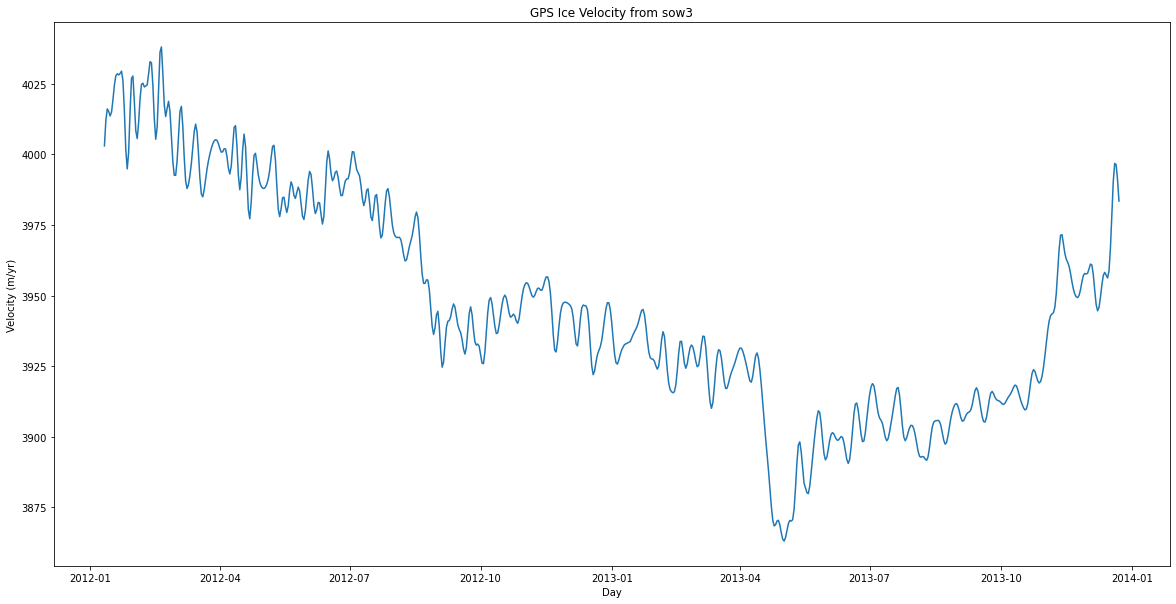

In [29]:
'''

Get ice velocity from pre-processed GPS solutions 

'''

# select GPS source
data_source = "brendan"
station = "sow3"

# set some parameters for linearly interpolating velocity data to replace spike artifacts from numerical differentiation
spike_height = 2e-5
kde_width = 2.5

# get the gps ice velocity curve
gps_velocity,gps_time_vect = gps_ice_velocity(data_source,station,spike_height,kde_width)

# get rid of some low velcoity artifacts at the front of the data
gps_velocity = gps_velocity[2:]
gps_time_vect = gps_time_vect[2:]

# design a lowpass filter- the gps ice velocities we calculated are average values for each day, so fs = 1/86400
fs = 1/86400
ny = fs/2
cutoff = fs/6
b, a = butter(4, cutoff/ny, 'low')

# lowpass filter the gps ice velocity
filt_gps_velocity = filtfilt(b, a, gps_velocity)

# convert from m/s to m/yr
filt_gps_velocity = filt_gps_velocity * 86400 * 365

# make a basic plot
fig,ax = plt.subplots(figsize = (20,10))
plt.plot(gps_time_vect,filt_gps_velocity)
plt.xlabel("Day")
plt.ylabel("Velocity (m/yr)")
plt.title("GPS Ice Velocity from " + station)
plt.show()

In [ ]:
'''

Get daily stacks of vertical event waveforms

'''

# set the cluster of interest
cluster = 0
num_clusters = 2

# load catalog
ds = pyasdf.ASDFDataSet("outputs/detections/template_matching_catalog.h5",mode='r')

# extract times for each event in the dataset
detection_times = []
for event in ds.events:
    detection_times.append(event.origins[0].time.datetime)

# load clustering results
cluster_file = h5py.File("outputs/clustering/" + str(num_clusters) + "_cluster_results.h5","r")
predictions = np.array(list(cluster_file["cluster_index"]))
centroids = list(cluster_file["centroids"])
cluster_file.close()

# read correlation results for that cluster and its centroid
correlation_file = h5py.File("outputs/clustering/cluster_" + str(cluster) + "_correlations.h5",'r')
correlation_coefficients = np.array(correlation_file['correlation_coefficients'])
shifts = np.array(correlation_file['shifts'])
correlation_file.close()

# set parameters for stacking
# note: the correlations above were computed using the input waves for k-shape clustering. That data was downsampled to 2.1 Hz to speed up clustering! 
# so the shift values from that computation need to be multiplied by (100 Hz / 2.1 Hz) to properly align the 100 Hz waveforms! 
s = types.SimpleNamespace()
s.detection_times = np.array(detection_times)[predictions == cluster]
s.fs = 100
s.freq = [0.05,1]
s.station = "PIG2"
s.channel = "HHZ"
s.trace_length = 500
s.shifts = shifts * (100/2.1)
s.correlation_coefficients = correlation_coefficients
s.data_path = data_path
daily_stacks = get_stacks(s)

# save stacks
home_dir = str(pathlib.Path().absolute())
stack_file = h5py.File("outputs/figures/daily_stacks.h5",'w')
stack_file.create_dataset("stacks",data=daily_stacks)
stack_file.close()

In [ ]:
'''

Plot timeseries of dispersive cluster events with waveforms and GPS ice velocity

'''

# set some parameters for the plot
cluster = 0
num_clusters = 2

# load catalog
ds = pyasdf.ASDFDataSet("outputs/detections/template_matching_catalog.h5",mode='r')

# extract times for each event in the dataset
detection_times = []
for event in ds.events:
    detection_times.append(event.origins[0].time.datetime)

# load clustering results
cluster_file = h5py.File("outputs/clustering/" + str(num_clusters) + "_cluster_results.h5","r")
predictions = np.array(list(cluster_file["cluster_index"]))
centroids = list(cluster_file["centroids"])
cluster_file.close()

# read correlation results for that cluster and its centroid
correlation_file = h5py.File("outputs/clustering/cluster_" + str(cluster) + "_correlations.h5",'r')
correlation_coefficients = np.array(correlation_file['correlation_coefficients'])
shifts = np.array(correlation_file['shifts'])
correlation_file.close()

# read daily stacks of waveforms
home_dir = str(pathlib.Path().absolute())
stack_file = h5py.File("outputs/figures/daily_stacks.h5",'r')
daily_stacks = np.array(stack_file["stacks"])
stack_file.close()

# make the plot
plot_events_and_gps(filt_gps_velocity,gps_time_vect,np.array(detection_times)[predictions == cluster],daily_stacks)